# Named Entity Recognition
- For a given word and its context window, estimate whether the given word is location or not

# 1. Download dataset
- CoNLL2003 

In [2]:
!wget https://data.deepai.org/conll2003.zip # Download dataset
!unzip conll2003.zip # Unzip dataset zip

--2022-04-08 11:04:04--  https://data.deepai.org/conll2003.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982975 (960K) [application/x-zip-compressed]
Saving to: ‘conll2003.zip’

conll2003.zip       100%[===================>] 959.94K  --.-KB/s    in 0.06s   

2022-04-08 11:04:04 (15.2 MB/s) - ‘conll2003.zip’ saved [982975/982975]

Archive:  conll2003.zip
  inflating: metadata                
  inflating: test.txt                
  inflating: train.txt               
  inflating: valid.txt               


## 2. Preprocess Dataset

In [3]:
with open("train.txt") as f:
  string = ''.join(f.readlines())
dataset = string.split('\n')

dataset[50:80]

["'s POS B-NP O",
 'representative NN I-NP O',
 'to TO B-PP O',
 'the DT B-NP O',
 'European NNP I-NP B-ORG',
 'Union NNP I-NP I-ORG',
 "'s POS B-NP O",
 'veterinary JJ I-NP O',
 'committee NN I-NP O',
 'Werner NNP I-NP B-PER',
 'Zwingmann NNP I-NP I-PER',
 'said VBD B-VP O',
 'on IN B-PP O',
 'Wednesday NNP B-NP O',
 'consumers NNS I-NP O',
 'should MD B-VP O',
 'buy VB I-VP O',
 'sheepmeat NN B-NP O',
 'from IN B-PP O',
 'countries NNS B-NP O',
 'other JJ B-ADJP O',
 'than IN B-PP O',
 'Britain NNP B-NP B-LOC',
 'until IN B-SBAR O',
 'the DT B-NP O',
 'scientific JJ I-NP O',
 'advice NN I-NP O',
 'was VBD B-VP O',
 'clearer JJR B-ADJP O',
 '. . O O']

In [4]:
from itertools import groupby

dataset_in_sentence = [list(group) for k, group in groupby(dataset, lambda x: x == "") if not k]
dataset_in_sentence[:5]

[['-DOCSTART- -X- -X- O'],
 ['EU NNP B-NP B-ORG',
  'rejects VBZ B-VP O',
  'German JJ B-NP B-MISC',
  'call NN I-NP O',
  'to TO B-VP O',
  'boycott VB I-VP O',
  'British JJ B-NP B-MISC',
  'lamb NN I-NP O',
  '. . O O'],
 ['Peter NNP B-NP B-PER', 'Blackburn NNP I-NP I-PER'],
 ['BRUSSELS NNP B-NP B-LOC', '1996-08-22 CD I-NP O'],
 ['The DT B-NP O',
  'European NNP I-NP B-ORG',
  'Commission NNP I-NP I-ORG',
  'said VBD B-VP O',
  'on IN B-PP O',
  'Thursday NNP B-NP O',
  'it PRP B-NP O',
  'disagreed VBD B-VP O',
  'with IN B-PP O',
  'German JJ B-NP B-MISC',
  'advice NN I-NP O',
  'to TO B-PP O',
  'consumers NNS B-NP O',
  'to TO B-VP O',
  'shun VB I-VP O',
  'British JJ B-NP B-MISC',
  'lamb NN I-NP O',
  'until IN B-SBAR O',
  'scientists NNS B-NP O',
  'determine VBP B-VP O',
  'whether IN B-SBAR O',
  'mad JJ B-NP O',
  'cow NN I-NP O',
  'disease NN I-NP O',
  'can MD B-VP O',
  'be VB I-VP O',
  'transmitted VBN I-VP O',
  'to TO B-PP O',
  'sheep NN B-NP O',
  '. . O O']]

### 2.1 Make Data Loader

In [5]:
window_size = 2 
sentence = dataset_in_sentence[4]
word_idx = 0
center_word = sentence[2].split(' ')[0]

# from word_idx - window_length until word_idx + window_length
def get_words_window(sentence, word_idx, window_size):
  idx_range = range( max(word_idx-window_size, 0), min(word_idx+window_size+1, len(sentence)))
  windowed_words = [sentence[idx].split(' ')[0].lower() for idx in idx_range]
  
  if word_idx < window_size:
    windowed_words = ['PAD'] * (window_size-word_idx) + windowed_words
  if word_idx + window_size >= len(sentence):
    windowed_words += ['PAD'] * (word_idx + window_size -len(sentence)+1)
  
  assert len(windowed_words) == 1+window_size*2, "The length of output has to follow window size"
  return windowed_words

print(sentence)
print(get_words_window(sentence, word_idx, window_size))
# center_word

['The DT B-NP O', 'European NNP I-NP B-ORG', 'Commission NNP I-NP I-ORG', 'said VBD B-VP O', 'on IN B-PP O', 'Thursday NNP B-NP O', 'it PRP B-NP O', 'disagreed VBD B-VP O', 'with IN B-PP O', 'German JJ B-NP B-MISC', 'advice NN I-NP O', 'to TO B-PP O', 'consumers NNS B-NP O', 'to TO B-VP O', 'shun VB I-VP O', 'British JJ B-NP B-MISC', 'lamb NN I-NP O', 'until IN B-SBAR O', 'scientists NNS B-NP O', 'determine VBP B-VP O', 'whether IN B-SBAR O', 'mad JJ B-NP O', 'cow NN I-NP O', 'disease NN I-NP O', 'can MD B-VP O', 'be VB I-VP O', 'transmitted VBN I-VP O', 'to TO B-PP O', 'sheep NN B-NP O', '. . O O']
['PAD', 'PAD', 'the', 'european', 'commission']


In [6]:
import gensim.downloader

wrd2vec = gensim.downloader.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [7]:
word_idx = 0
words_window = get_words_window(sentence, word_idx, window_size)
print(words_window)
for word in words_window:
  if word in wrd2vec:
    print(word , wrd2vec[word][:10])

['PAD', 'PAD', 'the', 'european', 'commission']
the [ 0.04656    0.21318   -0.0074364 -0.45854   -0.035639   0.23643
 -0.28836    0.21521   -0.13486   -1.6413   ]
european [ 0.37636   0.1245    0.13028   0.024309  0.50706   0.18205  -0.44874
  0.35522   0.27065  -2.2199  ]
commission [ 4.7286e-01 -3.9634e-01 -2.6584e-01  1.2371e-02 -2.5906e-01 -2.5823e-01
  1.1492e-01 -1.4363e-01  2.0568e-03 -2.2627e+00]


In [8]:
# concat vectors
import torch

concat_vector = []
for word in words_window:
  if word in wrd2vec:
    concat_vector.append(torch.Tensor(wrd2vec[word]))
  else:
    zero_vector = torch.zeros(300)
    concat_vector.append(zero_vector)

concat_tensor = torch.cat(concat_vector)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  import sys


In [9]:
def make_flattened_vector_for_words_window(words_window):
  '''
  words_window (list): A list of words, with length 1+window_size*2
  '''
  output = [torch.Tensor(wrd2vec[word]) if word in wrd2vec else torch.zeros(300) for word in words_window ]
  
  return torch.cat(output)

'''
If you want to compare two tensors, and make sure those two tensors are exactly same (for every dimension)
you can use a booltensor.all()
'''
bool_tensor = concat_tensor == make_flattened_vector_for_words_window(words_window)
bool_tensor.all()
# (concat_tensor == make_flattened_vector_for_words_window(words_window)).all()
  
  

tensor(True)

In [10]:
concat_tensor = torch.cat(concat_vector)

print(concat_tensor[650] == concat_vector[2][49])
'''
[300 300 300 300 300]
1500 

concat_tensor's 1200th dimension
= 0th dimension of the 4th word

concat_tensor's 50th dimension
= 50th dimension of the 0th word

concat_tensor's 350th dimension
= 50th dimension of the 1st word


'''

tensor(False)


"\n[300 300 300 300 300]\n1500 \n\nconcat_tensor's 1200th dimension\n= 0th dimension of the 4th word\n\nconcat_tensor's 50th dimension\n= 50th dimension of the 0th word\n\nconcat_tensor's 350th dimension\n= 50th dimension of the 1st word\n\n\n"

In [11]:
import torch.nn as nn

hidden_size = 128
first_layer = nn.Linear(300*5, 128, bias=True)

In [12]:
first_layer.weight.shape

torch.Size([128, 1500])

In [13]:
first_layer.bias.shape

torch.Size([128])

In [14]:
hidden = first_layer(concat_tensor)
concat_tensor.shape, hidden.shape

(torch.Size([1500]), torch.Size([128]))

In [15]:

wx = torch.matmul(first_layer.weight, concat_tensor) 
b = first_layer.bias

wx+b

tensor([-1.3723e-01,  3.8097e-02,  1.4992e-01, -6.3142e-02,  5.3149e-02,
         2.3361e-01, -1.4420e-01,  1.1223e-01,  1.5945e-01, -8.9735e-02,
         1.4885e-01, -2.7940e-01, -2.2343e-01,  1.0200e-01, -1.0637e-01,
        -6.4971e-03,  1.8437e-01, -6.8376e-03,  1.9012e-02,  9.8348e-02,
        -1.3074e-01,  2.3055e-02, -1.4266e-01, -3.7543e-01,  3.7367e-02,
        -2.8981e-01, -1.2950e-01,  9.5905e-03,  1.6456e-02, -2.6561e-01,
        -2.1292e-01,  3.5753e-02,  9.2579e-02, -8.3063e-02, -2.1770e-01,
        -1.4796e-01,  7.5443e-02, -2.6057e-01,  2.4997e-01, -1.3558e-01,
        -7.6784e-02,  5.8302e-02, -2.3875e-01,  8.6042e-02,  1.0954e-01,
         1.8238e-01,  3.7254e-01, -1.8971e-02, -7.6749e-03,  1.8506e-02,
         2.3441e-01,  1.7420e-01,  8.6771e-02,  1.8304e-01,  9.7018e-02,
         3.2919e-01,  7.3461e-02, -1.3229e-01, -1.4962e-03,  2.6118e-01,
        -1.1710e-01,  4.9896e-02, -1.5409e-01,  1.3064e-01,  6.0479e-02,
        -2.1275e-02, -5.5834e-02,  2.6196e-01, -4.0

In [16]:
first_layer(concat_tensor)

tensor([-1.3723e-01,  3.8097e-02,  1.4992e-01, -6.3142e-02,  5.3149e-02,
         2.3361e-01, -1.4420e-01,  1.1223e-01,  1.5945e-01, -8.9735e-02,
         1.4885e-01, -2.7940e-01, -2.2343e-01,  1.0200e-01, -1.0637e-01,
        -6.4971e-03,  1.8437e-01, -6.8376e-03,  1.9012e-02,  9.8348e-02,
        -1.3074e-01,  2.3055e-02, -1.4266e-01, -3.7543e-01,  3.7367e-02,
        -2.8981e-01, -1.2950e-01,  9.5905e-03,  1.6456e-02, -2.6561e-01,
        -2.1292e-01,  3.5753e-02,  9.2579e-02, -8.3063e-02, -2.1770e-01,
        -1.4796e-01,  7.5443e-02, -2.6057e-01,  2.4997e-01, -1.3558e-01,
        -7.6784e-02,  5.8302e-02, -2.3875e-01,  8.6042e-02,  1.0954e-01,
         1.8238e-01,  3.7254e-01, -1.8971e-02, -7.6749e-03,  1.8506e-02,
         2.3441e-01,  1.7420e-01,  8.6771e-02,  1.8304e-01,  9.7018e-02,
         3.2919e-01,  7.3461e-02, -1.3229e-01, -1.4962e-03,  2.6118e-01,
        -1.1710e-01,  4.9896e-02, -1.5409e-01,  1.3064e-01,  6.0479e-02,
        -2.1275e-02, -5.5834e-02,  2.6196e-01, -4.0

In [17]:
print(first_layer.weight.shape)
first_layer.weight[0]

torch.Size([128, 1500])


tensor([-0.0021, -0.0036,  0.0254,  ..., -0.0170,  0.0081,  0.0092],
       grad_fn=<SelectBackward0>)

In [18]:
entire_output = []
for neuron in first_layer.weight:
  entire_output.append((neuron * concat_tensor).sum())
# entire_output
                    

In [19]:
words_window

['PAD', 'PAD', 'the', 'european', 'commission']

In [20]:
first_layer.weight[0][600:900]

tensor([ 0.0045,  0.0060,  0.0155, -0.0059,  0.0100,  0.0072, -0.0148,  0.0129,
         0.0248, -0.0161, -0.0034,  0.0046,  0.0034, -0.0067,  0.0006,  0.0204,
        -0.0159, -0.0097,  0.0204,  0.0251,  0.0130, -0.0193, -0.0179, -0.0198,
        -0.0232,  0.0125, -0.0227,  0.0008,  0.0179, -0.0227,  0.0225,  0.0174,
         0.0036,  0.0096,  0.0142,  0.0074, -0.0111, -0.0074,  0.0193, -0.0114,
         0.0047,  0.0047,  0.0003, -0.0239,  0.0057, -0.0253, -0.0184, -0.0153,
         0.0092, -0.0185, -0.0026,  0.0006, -0.0233,  0.0231, -0.0208, -0.0083,
         0.0174, -0.0052, -0.0053,  0.0115, -0.0051, -0.0244, -0.0021, -0.0101,
        -0.0102,  0.0131,  0.0011,  0.0094, -0.0064,  0.0118,  0.0211,  0.0039,
         0.0222,  0.0046, -0.0239, -0.0042, -0.0206, -0.0166, -0.0136, -0.0202,
        -0.0004,  0.0052, -0.0185,  0.0133, -0.0249, -0.0128,  0.0021, -0.0198,
        -0.0225, -0.0091, -0.0134,  0.0215, -0.0243,  0.0216, -0.0103,  0.0164,
        -0.0179, -0.0061,  0.0089, -0.02

In [21]:
hidden = first_layer(concat_tensor)
hidden_after_activation = torch.relu(hidden)
hidden[:20], hidden_after_activation[:20]

(tensor([-0.1372,  0.0381,  0.1499, -0.0631,  0.0531,  0.2336, -0.1442,  0.1122,
          0.1594, -0.0897,  0.1489, -0.2794, -0.2234,  0.1020, -0.1064, -0.0065,
          0.1844, -0.0068,  0.0190,  0.0983], grad_fn=<SliceBackward0>),
 tensor([0.0000, 0.0381, 0.1499, 0.0000, 0.0531, 0.2336, 0.0000, 0.1122, 0.1594,
         0.0000, 0.1489, 0.0000, 0.0000, 0.1020, 0.0000, 0.0000, 0.1844, 0.0000,
         0.0190, 0.0983], grad_fn=<SliceBackward0>))

In [22]:
hidden.shape

torch.Size([128])

In [23]:
second_layer = nn.Linear(in_features=128, out_features=1, bias=True)


In [24]:
second_output = second_layer(hidden_after_activation)
final_prediction = torch.sigmoid(second_output)
words_window, final_prediction

(['PAD', 'PAD', 'the', 'european', 'commission'],
 tensor([0.5088], grad_fn=<SigmoidBackward0>))

In [25]:
torch.sigmoid(torch.zeros(1))

tensor([0.5000])

In [26]:
get_words_window(sentence, word_idx, window_size)


['PAD', 'PAD', 'the', 'european', 'commission']

In [27]:
sentence[:5]

['The DT B-NP O',
 'European NNP I-NP B-ORG',
 'Commission NNP I-NP I-ORG',
 'said VBD B-VP O',
 'on IN B-PP O']

## 3. Make a Neural Network Model

In [28]:
class NERModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.first_layer = nn.Linear(in_features=1500, out_features=128)
    self.second_layer = nn.Linear(in_features=128, out_features=1)
    
  def forward(self, x):
#     print("forward is called")
#     print(x)
    hidden_representation = self.first_layer(x)
    hidden_after_activation = torch.relu(hidden_representation)
    scalar_value = self.second_layer(hidden_after_activation)
    probability = torch.sigmoid(scalar_value)
    return probability
  

model = NERModel()
print(type(model))
model(concat_tensor)

<class '__main__.NERModel'>


tensor([0.5001], grad_fn=<SigmoidBackward0>)

## 4. Implement a train loop

In [29]:
'''
For Epoch in NumEpochs:
  For DataSample in TrainingSet:
    TrainWithDataSample(Model, DataSample)

'''

'\nFor Epoch in NumEpochs:\n  For DataSample in TrainingSet:\n    TrainWithDataSample(Model, DataSample)\n\n'

In [30]:
dataset_in_sentence[4]

['The DT B-NP O',
 'European NNP I-NP B-ORG',
 'Commission NNP I-NP I-ORG',
 'said VBD B-VP O',
 'on IN B-PP O',
 'Thursday NNP B-NP O',
 'it PRP B-NP O',
 'disagreed VBD B-VP O',
 'with IN B-PP O',
 'German JJ B-NP B-MISC',
 'advice NN I-NP O',
 'to TO B-PP O',
 'consumers NNS B-NP O',
 'to TO B-VP O',
 'shun VB I-VP O',
 'British JJ B-NP B-MISC',
 'lamb NN I-NP O',
 'until IN B-SBAR O',
 'scientists NNS B-NP O',
 'determine VBP B-VP O',
 'whether IN B-SBAR O',
 'mad JJ B-NP O',
 'cow NN I-NP O',
 'disease NN I-NP O',
 'can MD B-VP O',
 'be VB I-VP O',
 'transmitted VBN I-VP O',
 'to TO B-PP O',
 'sheep NN B-NP O',
 '. . O O']

In [31]:
loss_fn = torch.nn.BCELoss() #this is the predefined binary cross entropy function

In [32]:
from math import log
-log(0.5) #this is the average of the binary cross entropy

0.6931471805599453

In [33]:
model = NERModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

'''
on-the-fly method to get a data sample
'''
for sentence in dataset_in_sentence[:30]:
  for wrd_idx in range(len(sentence)):
    words_window = get_words_window(sentence, wrd_idx, 2)
    flattened_vector = make_flattened_vector_for_words_window(words_window)
    prediction = model(flattened_vector)
    
    label = sentence[wrd_idx].split(' ')[-1] in ('B-LOC', 'I-LOC') #check if B-loc and I-loc is in the sentence, and if the there is the word it'll return True or else False.
    #We want to make the False prediction close to 0 and True prediction close to 1 
    label_tensor = torch.Tensor([label]).float()
    loss = loss_fn(prediction, label_tensor) # Calculate how wrong is the estimation, which is loss. We use binary cross entropy.This is homework so we use predefined loss_fn()
    loss.backward() # Backpropagate the loss to get the gradient
    optimizer.step() # Update the parameters
    optimizer.zero_grad() # Reset the gradient of the parameters
    print(loss.item())
#     print(prediction.item(), label_tensor, loss.item())
#     print(words_window, prediction, label)
    break

0.6671698093414307
0.6444815993309021
0.6809184551239014
0.8242167830467224
0.6244630217552185
0.8300137519836426
0.5904390811920166
0.603347897529602
0.5509924292564392
0.5199240446090698
0.49354010820388794
0.5153568387031555
0.5849422812461853
0.4189315140247345
0.29067838191986084
0.3925616145133972
0.33891281485557556
0.20003171265125275
1.0147393941879272
0.7319843173027039
0.2602522075176239
0.6447174549102783
0.49614378809928894
0.8076680302619934
0.26280415058135986
0.2761423885822296
0.24870748817920685
0.3749808073043823
0.1398693174123764
0.1900891661643982


In [34]:
'''
Prepare training data before we start the training stage
'''



'\nPrepare training data before we start the training stage\n'

In [35]:
def prepare_dataset(dataset_in_sentence):
  total_data_sample = []
  for sentence in dataset_in_sentence[:100]:
    for wrd_idx in range(len(sentence)):
      words_window = get_words_window(sentence, wrd_idx, 2)
      flattened_vector = make_flattened_vector_for_words_window(words_window)    
      label = sentence[wrd_idx].split(' ')[-1] in ('B-LOC', 'I-LOC')
      data_sample = (flattened_vector, label)
      total_data_sample.append(data_sample)
  return total_data_sample

total_data_sample = prepare_dataset(dataset_in_sentence)

In [36]:
len(total_data_sample), total_data_sample[400]

(1529,
 (tensor([-0.4737, -0.1800, -0.4015,  ...,  1.0656, -0.0622,  0.4095]), False))

In [37]:
class WindowWordDataset:
  def __init__(self, txt_path):
    
    with open(txt_path) as f:
      string = ''.join(f.readlines())
    dataset = string.split('\n')
    self.data_in_sentence = [list(group) for k, group in groupby(dataset, lambda x: x == "") if not k]
    self.data_samples = self.prepare_entire_data_sample()
    
  def prepare_entire_data_sample(self):
    total_data_sample = []
    for sentence in self.data_in_sentence:
      for wrd_idx in range(len(sentence)):
        words_window = get_words_window(sentence, wrd_idx, 2)
        flattened_vector = make_flattened_vector_for_words_window(words_window)    
        label = sentence[wrd_idx].split(' ')[-1] in ('B-LOC', 'I-LOC')
        data_sample = (flattened_vector, label, words_window)
        total_data_sample.append(data_sample)
    return total_data_sample
  
  def __len__(self):
    return len(self.data_samples)
  
  def __getitem__(self, idx):
    return self.data_samples[idx][:2]
  
dataset = WindowWordDataset('train.txt')

In [38]:
len(dataset)

204567

In [39]:
dataset[245]

(tensor([ 1.0857,  0.1658, -0.7905,  ...,  0.0020,  0.7095,  0.2967]), False)

In [40]:
from torch.utils.data import DataLoader

def custom_collate_fn(raw_batch):
  '''
  collate raw batch (a list of tuple data sample)
  '''
  
  input_vectors = []
  labels = []
  for data_sample in raw_batch:
    input_vector = data_sample[0]
    label = data_sample[1]
    
    input_vectors.append(input_vector)
    labels.append(label)
#   print(input_vectors)
#   print(labels)
  
  input_tensor = torch.stack(input_vectors) # stack a list of tensor into a new dimension
#   concat_tensor = torch.cat(input_vectors) # this concatenate to an existing dimension
  label_tensor = torch.Tensor(labels)
#   print(input_tensor.shape, concat_tensor.shape)
  return input_tensor, label_tensor 
  

train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
batch = next(iter(train_loader))
batch

(tensor([[ 0.2685,  0.2927, -0.5862,  ..., -0.5182,  0.7469, -0.2239],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.7256, -0.1930,  0.2275],
         [ 0.5531, -0.3117, -0.5440,  ..., -0.3422, -0.0224,  0.1368],
         ...,
         [ 0.0381, -0.0272, -0.0636,  ..., -0.2641, -0.6152,  0.1971],
         [-0.2576, -0.0571, -0.6719,  ...,  0.0000,  0.0000,  0.0000],
         [-0.3266,  0.4179,  0.0121,  ...,  0.2830,  0.0779,  0.0713]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]))

In [41]:
len(train_loader) * train_loader.batch_size, len(train_loader.dataset)

(204560, 204567)

In [42]:
204567//16 * 16

204560

In [43]:
'''
Vanilla Gradient Descent

weights -= weights.grad * lr

'''

'\nVanilla Gradient Descent\n\nweights -= weights.grad * lr\n\n'

In [44]:
from tqdm import tqdm
import itertools 
model = NERModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)

loss_record = []
# num_epochs = 5
num_iteration = 0
target_num_iteration = 10000

# for epoch in tqdm(range(num_epochs)):
for batch in itertools.cycle(train_loader):
  input_tensor, label = batch # input_tensor = batch[0] // label = batch[1]
  prediction = model(input_tensor)
  loss = loss_fn(prediction, label.unsqueeze(1)) # Calculate loss
  loss.backward() # Backpropagate the loss to get the gradient
  optimizer.step() # Update the parameters
  optimizer.zero_grad() # Reset the gradient of the parameters
  loss_record.append(loss.item())
  num_iteration += 1 
  if num_iteration > target_num_iteration:
    break

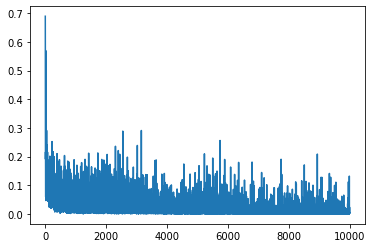

In [45]:
import matplotlib.pyplot as plt
plt.plot(loss_record)

In [46]:
for batch in train_loader:
  print(batch)
  break

# batch = next(iter(train_loader))

(tensor([[ 0.0466,  0.2132, -0.0074,  ..., -0.2008,  0.6151, -0.0029],
        [-0.7397, -0.6655,  0.5649,  ..., -0.4894,  0.1506, -0.7047],
        [-0.0013,  0.3651, -0.0774,  ..., -0.2641, -0.6152,  0.1971],
        ...,
        [ 0.1775, -0.0999, -0.3081,  ..., -0.3172,  0.2889, -0.1240],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5716, -0.0968, -0.0939,  ...,  0.0494, -0.2938,  0.2213]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


In [47]:
batch

(tensor([[ 0.0466,  0.2132, -0.0074,  ..., -0.2008,  0.6151, -0.0029],
         [-0.7397, -0.6655,  0.5649,  ..., -0.4894,  0.1506, -0.7047],
         [-0.0013,  0.3651, -0.0774,  ..., -0.2641, -0.6152,  0.1971],
         ...,
         [ 0.1775, -0.0999, -0.3081,  ..., -0.3172,  0.2889, -0.1240],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5716, -0.0968, -0.0939,  ...,  0.0494, -0.2938,  0.2213]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

## 5. Make Inference